In [1]:
import torch
import sys
import math

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import DataLoader
from itertools import cycle
from tqdm.auto import trange
from mpl_toolkits import mplot3d
from scipy.stats import gaussian_kde
from typing import Any, Tuple, Optional
from torch import Tensor

from sliceduot.utils_hyperbolic import *
from sliceduot.sliced_uot import unbalanced_sliced_ot
from sliceduot.utils_sampling import sampleWrappedNormal

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.12/site-packages/sliceduot-0.1.0-py3.12.egg/sliceduot/utils_hyperbolic.py:79: SyntaxWarning: invalid escape sequence '\i'
/opt/conda/lib/python3.12/site-packages/sliceduot-0.1.0-py3.12.egg/sliceduot/utils_hyperbolic.py:92: SyntaxWarning: invalid escape sequence '\i'
/opt/conda/lib/python3.12/site-packages/sliceduot-0.1.0-py3.12.egg/sliceduot/utils_hyperbolic.py:104: SyntaxWarning: invalid escape sequence '\i'
/opt/conda/lib/python3.12/site-packages/sliceduot-0.1.0-py3.12.egg/sliceduot/utils_hyperbolic.py:79: SyntaxWarning: invalid escape sequence '\i'
/opt/conda/lib/python3.12/site-packages/sliceduot-0.1.0-py3.12.egg/sliceduot/utils_hyperbolic.py:92: SyntaxWarning: invalid escape sequence '\i'
/opt/conda/lib/python3.12/sit

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

### Utils Plot

In [3]:
## From https://colab.research.google.com/drive/1kSdmi2r6QMO7gI8YPqeiWoW2ayxcu1MY?usp=sharing#scrollTo=LFl3I-ycM0vJ

eps = 1e-7
max_clamp_norm = 40
max_norm = 85
ln_2: torch.Tensor = math.log(2)

radius = torch.Tensor([1.0]).to(device)


def expand_proj_dims(x: torch.Tensor) -> torch.Tensor:
    zeros = torch.zeros(x.shape[:-1] + torch.Size([1])).to(x.device).to(x.dtype)
    return torch.cat((zeros, x), dim=-1)

# We will use this clamping technique to ensure numerical stability of the Exp and Log maps
class LeakyClamp(torch.autograd.Function):
    @staticmethod
    def forward(ctx: Any, x: torch.Tensor, min: float, max: float) -> torch.Tensor:
        ctx.save_for_backward(x.ge(min) * x.le(max))
        return torch.clamp(x, min=min, max=max)

    @staticmethod
    def backward(ctx: Any, grad_output: torch.Tensor) -> Tuple[torch.Tensor, None, None]:
        mask, = ctx.saved_tensors
        mask = mask.type_as(grad_output)
        return grad_output * mask + grad_output * (1 - mask) * eps, None, None

def clamp(x: torch.Tensor, min: float = float("-inf"), max: float = float("+inf")) -> torch.Tensor:
    return LeakyClamp.apply(x, min, max)

def cosh(x: torch.Tensor) -> torch.Tensor:
    x = clamp(x, min=-max_norm, max=max_norm)
    return torch.cosh(x)

def sinh(x: torch.Tensor) -> torch.Tensor:
    x = clamp(x, min=-max_norm, max=max_norm)
    return torch.sinh(x)

# Exp map for the origin has a special form which doesn't need the Lorentz norm
def exp_map_mu0(x: Tensor, radius: Tensor) -> Tensor:
    assert x[..., 0].allclose(torch.zeros_like(x[..., 0]))
    x = x[..., 1:]
    x_norm = torch.norm(x, p=2, keepdim=True, dim=-1) / radius
    x_normed = F.normalize(x, p=2, dim=-1) * radius
    ret = torch.cat((cosh(x_norm) * radius, sinh(x_norm) * x_normed), dim=-1)
    assert torch.isfinite(ret).all()
    return ret

def minkowski_kernel_density(grid, X, sig, weight=None):
    if weight is None:
        weight = torch.ones((X.shape[0])) / X.shape[0]
    kernel = minkowski_ip2(grid, X)
#     kernel = torch.arccosh(-kernel)
    kernel = torch.arccosh(torch.clamp(-kernel, min=1+1e-5))
    kernel = (-kernel / sig).exp()
    kernel = torch.matmul(kernel.T, weight)
    return kernel


# Helper function to do the plotting
def plot_density(xy_poincare, probs, radius, mu=None, ax=None, cmap='Oranges'):
    axis_lim = 1.1
    
    if ax is None:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)

    x = xy_poincare[:, 0].view(-1, 100).detach().cpu()
    y = xy_poincare[:, 1].view(-1, 100).detach().cpu()
    z = probs.view(-1, 100).detach().cpu()
    range_lim = 2
    # Define points within circle
    if mu is not None:
        mu = mu.cpu().numpy()
        plt.plot(mu[:, 0], mu[:, 1], 'b+')

    cnt = ax.contourf(x, y, z, 100, antialiased=False, cmap=cmap)

    ## Remove aliasing from pdf rendering (https://stackoverflow.com/questions/15822159/aliasing-when-saving-matplotlib-filled-contour-plot-to-pdf-or-eps)
    # for c in cnt.collections:
    #     c.set_edgecolor("face")
    ax.axis('off')

    # draw some fancy circle
    circle = plt.Circle((0, 0), 1, color='k', linewidth=2, fill=False)
    ax.add_patch(circle)
    # Makes the circle look like a circle
    ax.axis('equal')
    ax.set_xlim(-axis_lim, axis_lim)
    ax.set_ylim(-axis_lim, axis_lim)

In [4]:
def plot_distrib(X, ax, weights=None, cmap='Oranges'):
    """
        X must be on the Lorentz model
    """
    kernel = gaussian_kde(X.detach().cpu().numpy().T, weights=weights)

    # Map x, y coordinates on tangent space at origin to manifold (Lorentz model).
    x = np.arange(-5, 5, 0.1)
    y = np.arange(-5, 5, 0.1)
    x, y = np.meshgrid(x, y)
    x = torch.Tensor(x).view(-1, 1)
    y = torch.Tensor(y).view(-1, 1)
    twodim = torch.cat([x, y], dim=1)
    threedim = expand_proj_dims(twodim)
    clamped_threedim = clamp(threedim, min=-max_clamp_norm,
          max=max_clamp_norm)

    on_mani = exp_map_mu0(clamped_threedim, radius.cpu())
        
    probs = torch.tensor(kernel.pdf(on_mani.T.detach().cpu().numpy()))
    # Calculate the poincare coordinates
    xy_poincare = lorentz_to_poincare(on_mani.squeeze(), radius.cpu())
    plot_density(xy_poincare, probs, radius.cpu(),ax=ax, cmap=cmap)

In [5]:
def plot_distrib2(X, ax, weights=None, cmap='Oranges'):
    """
        X must be on the Lorentz model
    """
    X_poincare = lorentz_to_poincare(X).detach().cpu()
    kernel = gaussian_kde(X_poincare.numpy().T, weights=weights)

    # Map x, y coordinates on tangent space at origin to manifold (Lorentz model).
    x = np.arange(-5, 5, 0.1)
    y = np.arange(-5, 5, 0.1)
    x, y = np.meshgrid(x, y)
    x = torch.Tensor(x).view(-1, 1)
    y = torch.Tensor(y).view(-1, 1)
    twodim = torch.cat([x, y], dim=1)
    threedim = expand_proj_dims(twodim)
    clamped_threedim = clamp(threedim, min=-max_clamp_norm,
          max=max_clamp_norm)

    on_mani = exp_map_mu0(clamped_threedim, radius.cpu())
    on_mani_poincare = lorentz_to_poincare(on_mani)
    
    probs = torch.tensor(kernel.pdf(on_mani_poincare.T.detach().cpu().numpy()))
    # Calculate the poincare coordinates
    xy_poincare = lorentz_to_poincare(on_mani.squeeze(), radius.cpu())
    plot_density(xy_poincare, probs, radius.cpu(),ax=ax, cmap=cmap)


In [6]:
# First plot: sig=0.1
def plot_distrib3(X, ax, weights=None, sig=0.2, cmap='Oranges'):
    """
        X must be on the Lorentz model
    """

    # Map x, y coordinates on tangent space at origin to manifold (Lorentz model).
    x = np.arange(-5, 5, 0.1)
    y = np.arange(-5, 5, 0.1)
    x, y = np.meshgrid(x, y)
    x = torch.Tensor(x).view(-1, 1)
    y = torch.Tensor(y).view(-1, 1)
    twodim = torch.cat([x, y], dim=1)
    threedim = expand_proj_dims(twodim)
    clamped_threedim = clamp(threedim, min=-max_clamp_norm, max=max_clamp_norm)

    on_mani = exp_map_mu0(clamped_threedim, radius.cpu())
    on_mani_poincare = lorentz_to_poincare(on_mani)
    
    probs = minkowski_kernel_density(on_mani, X, weight=weights, sig=sig)
    # Calculate the poincare coordinates
    xy_poincare = lorentz_to_poincare(on_mani.squeeze(), radius.cpu())
    plot_density(xy_poincare, probs, radius.cpu(),ax=ax, cmap=cmap)


# Generate and plot first mixture of wrapped Normal Distribution

In [7]:
Nsample_target = 2000
a = torch.ones((Nsample_target,)) 

# First mode
mu = torch.tensor([-0.55, 0], dtype=torch.float, device=device)
mu = poincare_to_lorentz(mu)
Sigma = 0.05 * torch.tensor([[0.5,0],[0,15]], dtype=torch.float, device=device)
X_target_1 = sampleWrappedNormal(mu, Sigma, Nsample_target) # lorentz_to_poincare(sampleWrappedNormal(mu, Sigma, 10000))


# Second mode
mu = torch.tensor([0.55, 0], dtype=torch.float, device=device)
mu = poincare_to_lorentz(mu)
Sigma = 0.05 * torch.tensor([[0.5,0],[0,15]], dtype=torch.float, device=device)
X_target_2 = sampleWrappedNormal(mu, Sigma, Nsample_target) # lorentz_to_poincare(sampleWrappedNormal(mu, Sigma, 10000))

# # Third mode - outlier
# mu = torch.tensor([0.0, 0], dtype=torch.float)
# mu = poincare_to_lorentz(mu)
# Sigma = 0.1 * torch.tensor([[1,0],[0,1]], dtype=torch.float, device=device)
# X_target_3 = sampleWrappedNormal(mu, Sigma, Nsample_target) # lorentz_to_poincare(sampleWrappedNormal(mu, Sigma, 10000))

# Concatenate
X_target = torch.concat((X_target_1, X_target_2), dim=0)
a = torch.concat((2* a, 2 * a))
a = a / a.sum()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


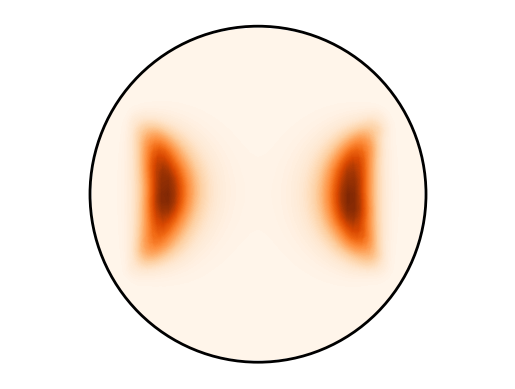

In [8]:
# Display
fig, ax = plt.subplots()
plot_distrib3(X_target.cpu(), ax, cmap='Oranges')
plt.show()

# Generate and plot second mixture of wrapped Normal Distribution

In [10]:
Nsample_src = 2000
a = torch.ones((Nsample_src)) 

# First mode
mu = torch.tensor([-0.8, 0], dtype=torch.float, device=device)
mu = poincare_to_lorentz(mu)
Sigma = 0.1 * torch.tensor([[1,0],[0,1]], dtype=torch.float, device=device)
X_src_1 = sampleWrappedNormal(mu, Sigma, Nsample_src) # lorentz_to_poincare(sampleWrappedNormal(mu, Sigma, 10000))

# Second mode
mu = torch.tensor([0.8, 0], dtype=torch.float, device=device)
mu = poincare_to_lorentz(mu)
Sigma = 0.1 * torch.tensor([[1,0],[0,1]], dtype=torch.float, device=device)
X_src_2 = sampleWrappedNormal(mu, Sigma, Nsample_src) # lorentz_to_poincare(sampleWrappedNormal(mu, Sigma, 10000))

# Second mode - outlier
mu = torch.tensor([0., 0.8], dtype=torch.float, device=device)
mu = poincare_to_lorentz(mu)
Sigma = 0.1 * torch.tensor([[1,0],[0,1]], dtype=torch.float, device=device)
X_src_3 = sampleWrappedNormal(mu, Sigma, Nsample_src) # lorentz_to_poincare(sampleWrappedNormal(mu, Sigma, 10000))

# Concatenate
X_src = torch.concat((X_src_1, X_src_2, X_src_3), dim=0)
a = torch.concat((2 * a, 2 * a, a))
a = a / a.sum()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


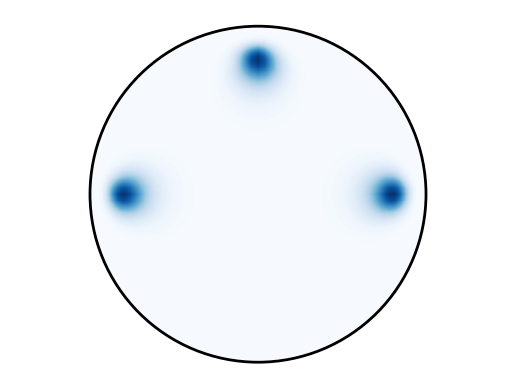

In [12]:
# Display
fig, ax = plt.subplots()
plot_distrib3(X_src.cpu(), ax, cmap='Blues')
plt.show()

# Marginals of RSOT on hyperbolic manifold
Using the Poincare geodesics.

In [13]:
rho1 = 0.005
rho2 = rho1

X_src_torch = torch.tensor(X_src, dtype=torch.float, device=device)
X_tgt_torch = torch.tensor(X_target, dtype=torch.float, device=device)

a = torch.full((X_src_torch.shape[0],), 1./X_src_torch.shape[0], dtype=X_src_torch.dtype, device=X_src_torch.device)
b = torch.full((X_tgt_torch.shape[0],), 1./X_tgt_torch.shape[0], dtype=X_tgt_torch.dtype, device=X_tgt_torch.device)

rsw, f, g, A, B, projs = unbalanced_sliced_ot(a, b, X_src_torch, X_tgt_torch, p=2, num_projections=100, 
                                              rho1=rho1, rho2=rho2, niter=500, type_proj="lorentz_geod")

/tmp/ipykernel_4215/2618916879.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_src_torch = torch.tensor(X_src, dtype=torch.float, device=device)
/tmp/ipykernel_4215/2618916879.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tgt_torch = torch.tensor(X_target, dtype=torch.float, device=device)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


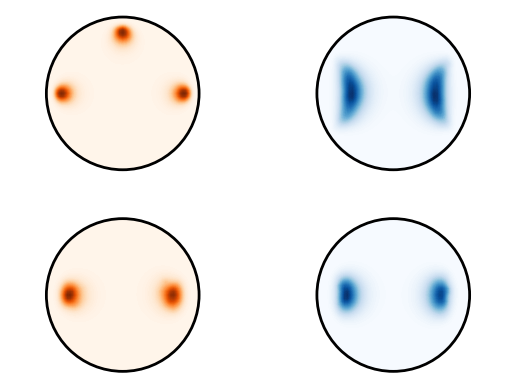

In [15]:
fig, ax = plt.subplots(2, 2)

plot_distrib3(X_src.cpu(), ax[0,0], weights=(a/a.sum()).cpu(), cmap='Oranges')
plot_distrib3(X_target.cpu(), ax[0,1], weights=(b/b.sum()).cpu(), cmap='Blues')

plot_distrib3(X_src.cpu(), ax[1,0], weights=(A/A.sum()).cpu(), cmap='Oranges')
plot_distrib3(X_target.cpu(), ax[1,1], weights=(B/B.sum()).cpu(), cmap='Blues')
plt.show()

/tmp/ipykernel_4215/1746768022.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_src_torch = torch.tensor(X_src, dtype=torch.float, device=device)
/tmp/ipykernel_4215/1746768022.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tgt_torch = torch.tensor(X_target, dtype=torch.float, device=device)
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjus

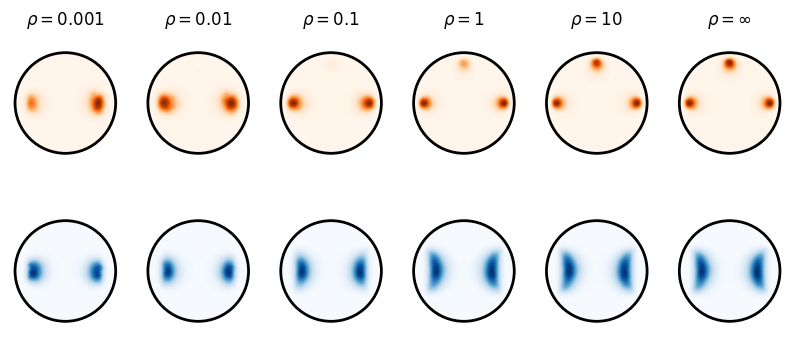

In [17]:
fig, ax = plt.subplots(2, 6, figsize=(10,4))


for i, rho1 in enumerate([0.001, 0.01, 0.1, 1, 10]):
#     rho1 = 0.1 # 1
    rho2 = rho1

    X_src_torch = torch.tensor(X_src, dtype=torch.float, device=device)
    X_tgt_torch = torch.tensor(X_target, dtype=torch.float, device=device)

    a = torch.full((X_src_torch.shape[0],), 1./X_src_torch.shape[0], dtype=X_src_torch.dtype, device=X_src_torch.device)
    b = torch.full((X_tgt_torch.shape[0],), 1./X_tgt_torch.shape[0], dtype=X_tgt_torch.dtype, device=X_tgt_torch.device)

    rsw, f, g, A, B, projs = unbalanced_sliced_ot(a, b, X_src_torch, X_tgt_torch, p=2, num_projections=100,
                                                  rho1=rho1, rho2=rho2, niter=1000, type_proj="lorentz_geod")
    

    plot_distrib3(X_src.cpu(), ax[0, i], (A/A.sum()).cpu(), cmap='Oranges')
    plot_distrib3(X_target.cpu(), ax[1,i], (B/B.sum()).cpu(), cmap='Blues')
    ax[0, i].set_title(r"$\rho=$"+str(rho1))
    
plot_distrib3(X_src.cpu(), ax[0,-1], a.cpu(), cmap='Oranges')
plot_distrib3(X_target.cpu(), ax[1,-1], b.cpu(), cmap='Blues')
ax[0,-1].set_title(r"$\rho=\infty$")
    
plt.show()